In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier


In [14]:
# Load the cleaned dataset
df = pd.read_csv("data/HR_processed_cleaned.csv")

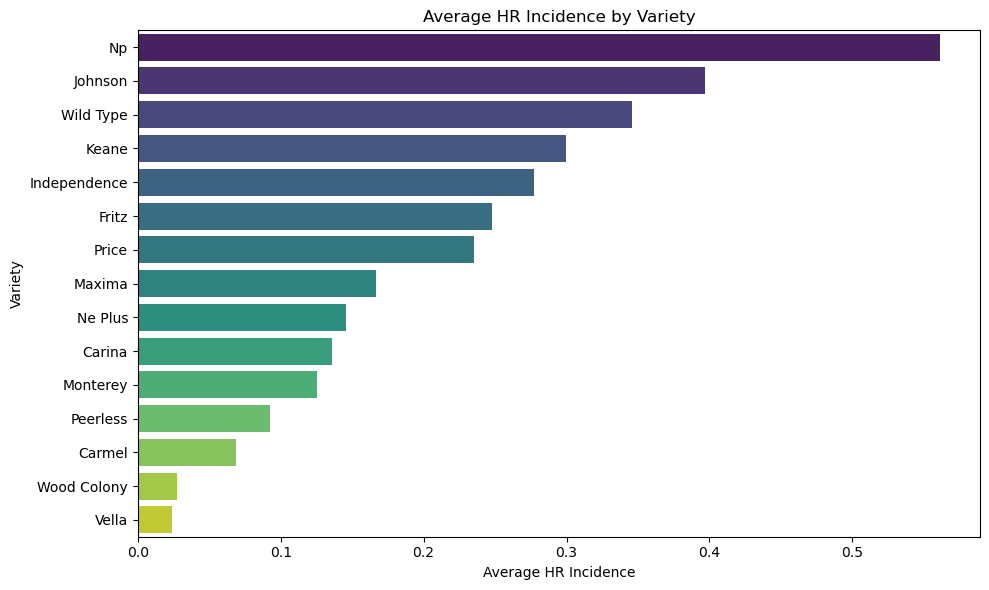

In [15]:
# Group by Variety and calculate average HR incidence
variety_hr = df.groupby("Variety")["HR Incidence"].mean().sort_values(ascending=False).reset_index()

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=variety_hr, x="HR Incidence", y="Variety", palette="viridis")
plt.title("Average HR Incidence by Variety")
plt.xlabel("Average HR Incidence")
plt.ylabel("Variety")
plt.tight_layout()
plt.show()


Model Performance (with Variety):
Mean Squared Error: 0.0647
R-squared: 0.4405

Top 10 Important Features (with Variety):
                                     Feature  Importance
29                                Variety_Np    0.279212
8   Amt rain in last event>5days from assess    0.126983
15                        Rain 3rd week  Jan    0.112527
19                      Total_Trees_Assessed    0.083582
18         Rain within 10 days of assessment    0.063268
12                          No rain days Feb    0.030332
11                         Total rain Feb mm    0.029857
21                            Variety_Carmel    0.023344
31                             Variety_Price    0.021323
4                No of rain days since 1 Jan    0.020663


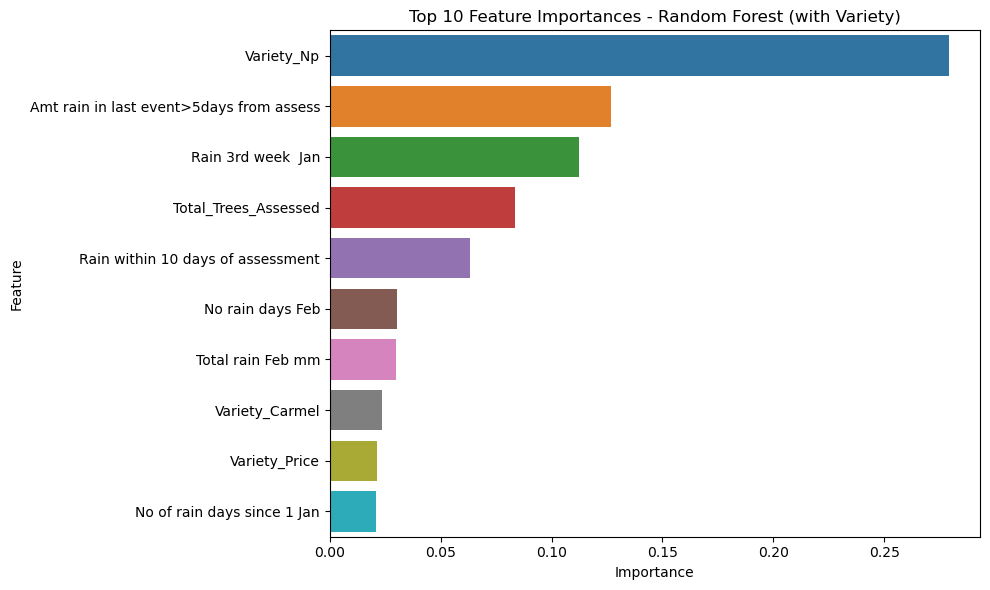

In [16]:
# Encode categorical feature (Variety) using one-hot encoding
categorical = pd.get_dummies(df["Variety"], prefix="Variety")

# Select numeric features only (excluding target)
target = "HR Incidence"
numeric_features = df.select_dtypes(include=["float64", "int64"]).drop(columns=[target])

# Combine numeric and encoded categorical features
X = pd.concat([numeric_features, categorical], axis=1)
y = df[target]

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict and evaluate
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Model Performance (with Variety):")
print(f"Mean Squared Error: {mse:.4f}")
print(f"R-squared: {r2:.4f}")

# Feature importance
importances = model.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

print("\nTop 10 Important Features (with Variety):")
print(feature_importance_df.head(10))

# Plot top features
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance_df.head(10), x="Importance", y="Feature")
plt.title("Top 10 Feature Importances - Random Forest (with Variety)")
plt.tight_layout()
plt.show()

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.89      0.89        28
           1       0.77      0.77      0.77        13

    accuracy                           0.85        41
   macro avg       0.83      0.83      0.83        41
weighted avg       0.85      0.85      0.85        41



/Users/subinseol/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


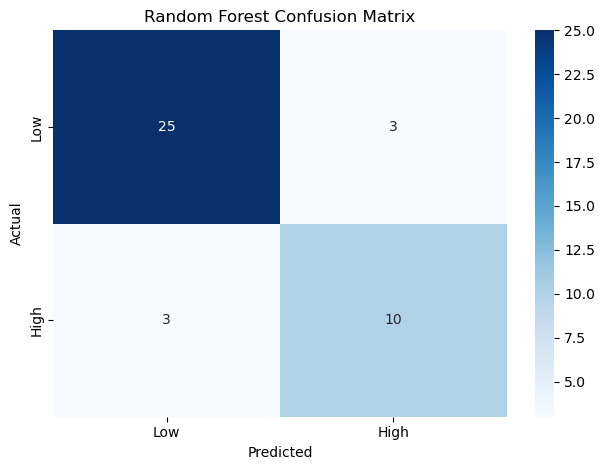

Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.86      0.89        28
           1       0.73      0.85      0.79        13

    accuracy                           0.85        41
   macro avg       0.83      0.85      0.84        41
weighted avg       0.86      0.85      0.86        41



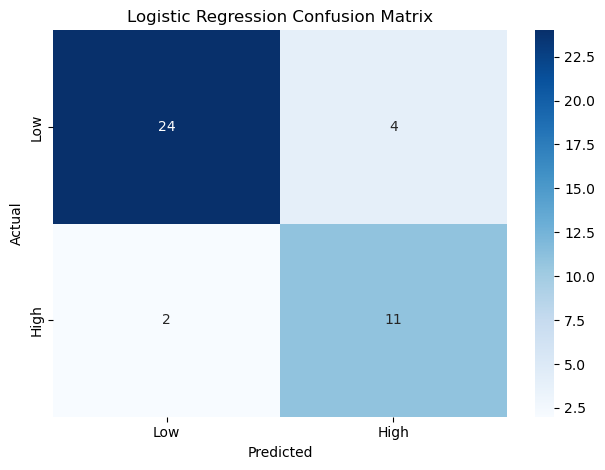

In [20]:
# Step 1: Create binary class
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression


threshold = 0.3
df["HR_Class"] = (df["HR Incidence"] >= threshold).astype(int)

# Step 2: Prepare features
X_cat = pd.get_dummies(df["Variety"], prefix="Variety")
X_num = df.select_dtypes(include=["float64", "int64"]).drop(columns=["HR Incidence", "HR_Class"])
X = pd.concat([X_num, X_cat], axis=1)
X.columns = X.columns.str.replace(r"[\\[\\]<>]", "", regex=True)  # sanitize column names

y = df["HR_Class"]

# Step 3: Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Step 4: Train models
rf = RandomForestClassifier(random_state=42)
lr = LogisticRegression(max_iter=1000)

rf.fit(X_train, y_train)
lr.fit(X_train, y_train)

# Step 5: Predictions
rf_preds = rf.predict(X_test)
lr_preds = lr.predict(X_test)

# Step 6: Evaluation function
def evaluate_model(name, y_true, y_pred):
    print(f"{name} Classification Report:")
    print(classification_report(y_true, y_pred))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Low", "High"], yticklabels=["Low", "High"])
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

# Step 7: Evaluate both models
evaluate_model("Random Forest", y_test, rf_preds)
evaluate_model("Logistic Regression", y_test, lr_preds)

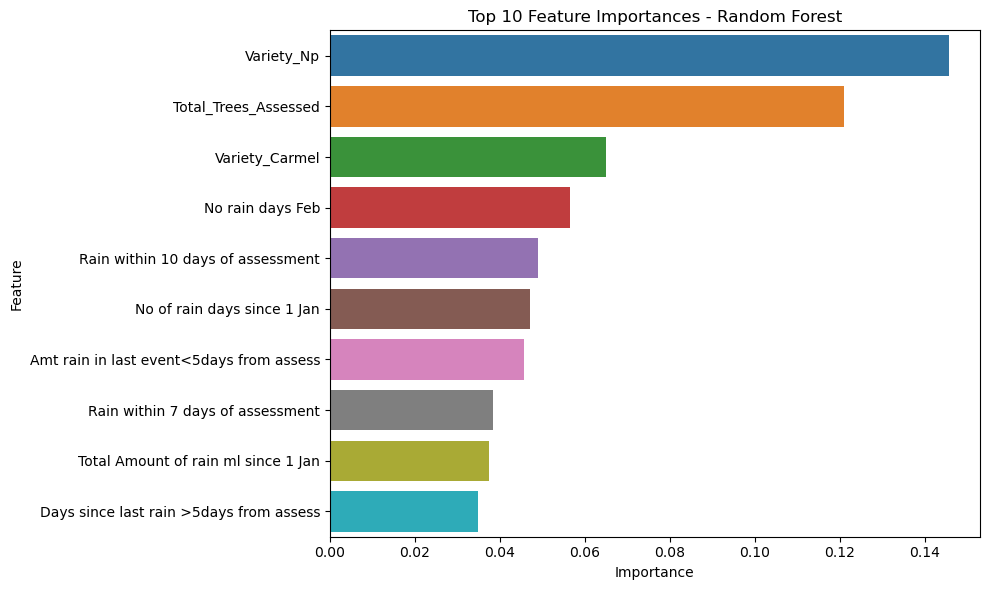

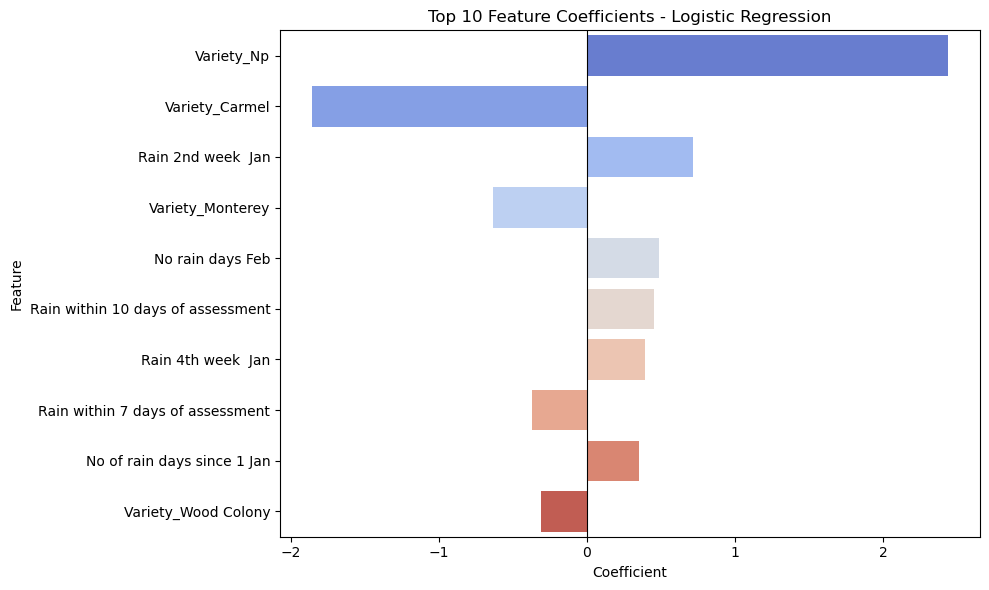

In [18]:
# Use the trained models and X (feature matrix) from earlier
# Step 1: Get feature names
feature_names = X.columns

# Step 2: Random Forest - Feature Importance
rf_importances = rf.feature_importances_
rf_df = pd.DataFrame({"Feature": feature_names, "Importance": rf_importances})
rf_df = rf_df.sort_values(by="Importance", ascending=False)

# Plot top 10
plt.figure(figsize=(10, 6))
sns.barplot(data=rf_df.head(10), x="Importance", y="Feature")
plt.title("Top 10 Feature Importances - Random Forest")
plt.tight_layout()
plt.show()

# Step 3: Logistic Regression - Coefficients (signed impact)
lr_coefs = lr.coef_[0]
lr_df = pd.DataFrame({"Feature": feature_names, "Coefficient": lr_coefs})
lr_df = lr_df.sort_values(by="Coefficient", key=abs, ascending=False)

# Plot top 10 coefficients
plt.figure(figsize=(10, 6))
sns.barplot(data=lr_df.head(10), x="Coefficient", y="Feature", palette="coolwarm")
plt.axvline(0, color='black', linewidth=0.8)
plt.title("Top 10 Feature Coefficients - Logistic Regression")
plt.tight_layout()
plt.show()

In [19]:
df["Orchard"].value_counts()

Orchard
Jubilee                13
Nutwood                12
Egan Rd                12
Walker Flat Almonds    10
Gone Nuts               8
Outback                 8
Nick Pezzaniti          8
Mullroo                 8
Mclaren Dr              8
Margooya                8
Belvedere               8
Cmv Lp                  8
Chatfield               8
Century Loxton          8
Yilgah                  8
Domenic Cavallaro       7
Gary Thorpe             6
Freeman Farming         6
Bennett                 6
Lake Powell             6
Meilman                 6
Carina                  6
Caernarvon              6
Vince Ruggiero          6
Big River Produce       6
Wemen                   6
Name: count, dtype: int64